In [1]:
## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

#Libaries for global profilling
##Mehalanobis distance
import scipy as sp
from scipy.spatial import distance
from sklearn.cluster import DBSCAN

import math
import numpy as np
from pandas import DataFrame
import datetime
from itertools import repeat
from sklearn import metrics

In [2]:
# read the data and show first 5 rows
data = pd.read_csv("E:\\bs140513_032310.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


# Phân tích và trực quan hóa dữ liệu

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


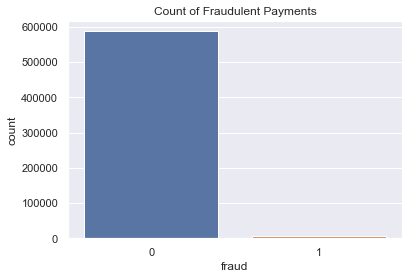

Number of normal examples:  587443
Number of fradulent examples:  7200


In [4]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

In [5]:
print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


<ipython-input-5-cc3083ece405>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())


In [6]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000
'es_sportsandtoys',345.366811,88.502738,49.525237


No handles with labels found to put in legend.


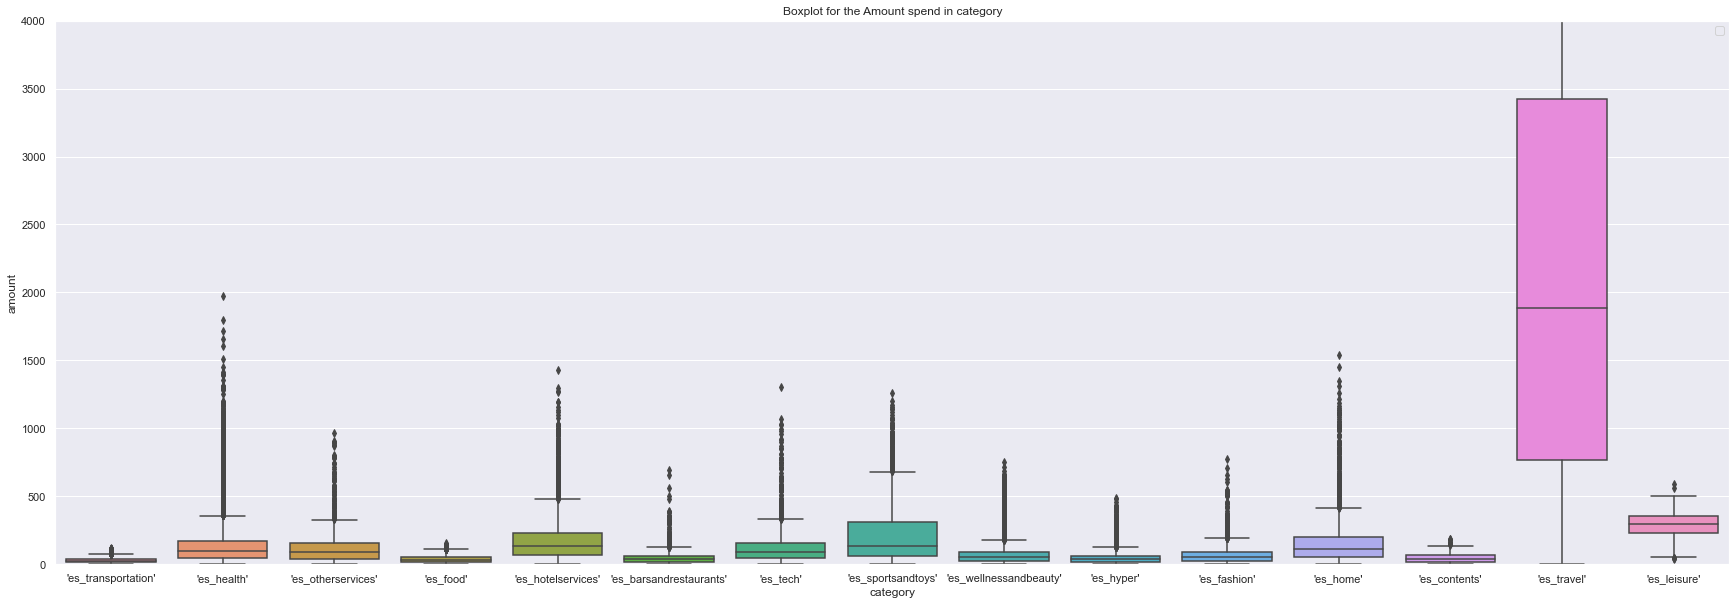

In [7]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

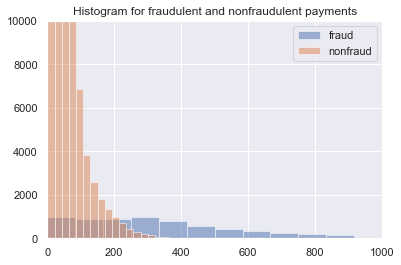

In [8]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

In [9]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


# Tiền xử lý dữ liệu

In [10]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [11]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [12]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [13]:
X = data_reduced.copy()
X.shape

(594643, 8)

In [14]:
y = data_reduced['fraud']
y.shape

(594643,)

In [15]:
X.shape, y.shape

((594643, 8), (594643,))

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

In [17]:
X_train.shape

(475714, 8)

In [18]:
X_test.shape

(118929, 8)

In [19]:
X_test.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
475714,147,1627,3,1,18,12,32.39,0
475715,147,605,4,1,30,12,20.85,0
475716,147,3167,2,1,45,3,27.43,0
475717,147,1447,6,1,18,12,28.65,0
475718,147,3191,4,1,18,12,5.27,0


In [20]:
X_train.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [21]:
from  scipy.stats import levene
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [22]:
#Chi-square cho biến gender
chisqt=pd.crosstab(data_reduced.gender, data_reduced['fraud'])
print(chisqt)

fraud        0     1
gender              
0         1171     7
1       319807  4758
2       265950  2435
3          515     0


In [23]:
c, p, dof, expected = stats.chi2_contingency(chisqt)
print (c)

393.4250821335444


In [24]:
print (p)

5.878948827350995e-85


In [25]:
print (dof)

3


In [26]:
print (expected)

[[1.16373665e+03 1.42633479e+01]
 [3.20635133e+05 3.92986716e+03]
 [2.65135366e+05 3.24963381e+03]
 [5.08764326e+02 6.23567418e+00]]


In [27]:
#Chi-square cho biến category
chisqt=pd.crosstab(data_reduced.category, data_reduced['fraud'])
print(chisqt)

fraud          0     1
category              
0           6253   120
1            885     0
2           6338   116
3          26254     0
4          14437  1696
5           1684   302
6           1196   548
7           5818   280
8             25   474
9            684   228
10          2020  1982
11          2212   158
12        505119     0
13           150   578
14         14368   718


In [28]:
c, p, dof, expected = stats.chi2_contingency(chisqt)
print (c)

193862.64201580346


In [29]:
print (p)

0.0


In [30]:
print (dof)

14


In [31]:
print (expected)

[[6.29583505e+03 7.71649544e+01]
 [8.74284327e+02 1.07156731e+01]
 [6.37585429e+03 7.81457110e+01]
 [2.59361138e+04 3.17886194e+02]
 [1.59376599e+04 1.95340061e+02]
 [1.96195330e+03 2.40466969e+01]
 [1.72288346e+03 2.11165355e+01]
 [6.02416477e+03 7.38352255e+01]
 [4.92958056e+02 6.04194449e+00]
 [9.00957408e+02 1.10425919e+01]
 [3.95354336e+03 4.84566370e+01]
 [2.34130379e+03 2.86962093e+01]
 [4.99002966e+05 6.11603399e+03]
 [7.19185299e+02 8.81470059e+00]
 [1.49033371e+04 1.82662875e+02]]


In [32]:
#Chi-square cho biến age
chisqt=pd.crosstab(data_reduced.age, data_reduced['fraud'])
print(chisqt)

fraud       0     1
age                
0        2404    48
1       57442   689
2      184966  2344
3      145376  1755
4      107615  1410
5       61956   686
6       26513   261
7        1171     7


In [33]:
c, p, dof, expected = stats.chi2_contingency(chisqt)
print (c)

44.14631302458024


In [34]:
print (p)

2.0021179263106975e-07


In [35]:
print (dof)

7


In [36]:
print (expected)

[[2.42231093e+03 2.96890739e+01]
 [5.74271437e+04 7.03856263e+02]
 [1.85042031e+05 2.26796918e+03]
 [1.45349522e+05 1.78147763e+03]
 [1.07704914e+05 1.32008617e+03]
 [6.18835241e+04 7.58475926e+02]
 [2.64498176e+04 3.24182409e+02]
 [1.16373665e+03 1.42633479e+01]]


## Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [38]:
formula = 'fraud ~ amount'

In [39]:
model = smf.glm(formula = formula, data=data_reduced, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  fraud   No. Observations:               594643
Model:                            GLM   Df Residuals:                   594641
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16295.
Date:                Wed, 15 Jun 2022   Deviance:                       32590.
Time:                        14:00:56   Pearson chi2:                 2.26e+16
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.5823      0.027   -240.804      0.0

In [40]:
print("Coefficeients")
print(result.params)
print()
print("p-Values")
print(result.pvalues)
print()
print("Dependent variables")
print(result.model.endog_names)

Coefficeients
Intercept   -6.582292
amount       0.023332
dtype: float64

p-Values
Intercept    0.0
amount       0.0
dtype: float64

Dependent variables
fraud


In [41]:
predictions = result.predict()
print(predictions[0:10])

[0.00153739 0.00348264 0.00258642 0.00206653 0.00317626 0.00252222
 0.00170928 0.00226401 0.0029402  0.0031527 ]


In [42]:
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]

In [43]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(data_reduced["fraud"], 
                       predictions_nominal))

[[586815    628]
 [  3170   4030]]


In [44]:
print(classification_report(data_reduced["fraud"], 
                            predictions_nominal, 
                            digits = 3))

              precision    recall  f1-score   support

           0      0.995     0.999     0.997    587443
           1      0.865     0.560     0.680      7200

    accuracy                          0.994    594643
   macro avg      0.930     0.779     0.838    594643
weighted avg      0.993     0.994     0.993    594643



In [45]:
features = data_reduced.copy()
labels = data_reduced['fraud']

In [46]:
x_train=features[:int(0.7*(len(data_reduced)))] 
x_test= features[int(0.7*(len(data_reduced))):] 
y_train=labels[:int(0.7*(len(data_reduced)))] 
y_test= labels[int(0.7*(len(data_reduced))):]

In [47]:
model = smf.glm(formula = formula, 
                data = x_train, 
                family = sm.families.Binomial())
result = model.fit()

In [48]:
predictions = result.predict(x_test)
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
print(classification_report(y_test, 
                            predictions_nominal, 
                            digits = 3))

              precision    recall  f1-score   support

           0      0.995     0.999     0.997    176461
           1      0.852     0.540     0.661      1932

    accuracy                          0.994    178393
   macro avg      0.923     0.770     0.829    178393
weighted avg      0.993     0.994     0.993    178393



In [49]:
from sklearn import metrics

In [50]:
print (metrics.mean_absolute_error(y_test, predictions_nominal))

0.005997993194800245


In [51]:
print (metrics.mean_squared_error(y_test, predictions_nominal))

0.005997993194800245


In [52]:
print (np.sqrt(metrics.mean_absolute_error(y_test, predictions_nominal)))

0.07744671196894187


# Local Profile 

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [54]:
# chuyen pca
feature = ['step','customer','age', 'gender', 'merchant','category','amount']
x = data_reduced.loc[:,feature].values
# separating target
y = data_reduced.loc[:,['fraud']].values
#Standardising features
x = StandardScaler().fit_transform(x)

In [55]:
pca = PCA(n_components=7)

pct = pca.fit_transform(x)

principal_df = pd.DataFrame(pct,columns=['pc1','pc2','pc3','pc4','pc5','pc6','pc7'])

PCA_df= pd.concat([principal_df,data_reduced[['fraud']]],axis=1)

In [56]:
PCA_df[:5]

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,fraud
0,0.646690,-2.322163,1.396192,0.124062,0.543384,0.472167,-0.014794,0
1,0.813723,-1.739090,-0.288989,0.340454,-1.366346,0.672478,-0.039261,0
2,-0.084071,-1.307207,-1.029788,-0.404402,0.914314,0.759400,-1.041571,0
3,0.720067,-2.031273,0.459542,0.161125,-0.493708,0.536637,-0.035059,0
4,0.822773,-1.910164,-0.232203,-1.916411,-0.736187,0.750930,-0.127248,0


In [57]:
del PCA_df['fraud']

In [58]:
import math
import numpy as np
from pandas import DataFrame
import datetime
from itertools import repeat

class HBOS:
        
    def __init__(self, log_scale=True, ranked=False, bin_info_array=[], mode_array=[], nominal_array=[]):
        self.log_scale = log_scale
        self.ranked = ranked
        self.bin_info_array = bin_info_array
        self.mode_array = mode_array
        self.nominal_array = nominal_array
        # self.histogram_list = []
        
    def fit(self, data):
        attr_size = len(data.columns)
        total_data_size = len(data)
        
        # init params if needed
        if len(self.bin_info_array) == 0:
            self.bin_info_array = list(repeat(-1, attr_size))
        
        if len(self.mode_array) == 0:
            self.mode_array = list(repeat('dynamic binwidth', attr_size))
            
        if len(self.nominal_array) == 0:
            self.nominal_array = list(repeat(False, attr_size))
        
        if self.ranked:
            self.log_scale = False
            
        normal = 1.0
        
        # calculate standard _bin size if needed
        for i in range(len(self.bin_info_array)):
            if self.bin_info_array[ i ] == -1:
                self.bin_info_array[ i ] = round(math.sqrt(len(data)))
                
        # initialize histogram
        self.histogram_list = []
        for i in range(attr_size):
            self.histogram_list.append([])
            
        # save maximum value for every attribute(needed to normalize _bin width)
        maximum_value_of_rows = data.apply(max).values
        
        # sort data
        sorted_data = data.apply(sorted)
        
        # create histograms
        for attrIndex in range(len(sorted_data.columns)):
            attr = sorted_data.columns[ attrIndex ]
            last = 0
            bin_start = sorted_data[ attr ][ 0 ]
            if self.mode_array[ attrIndex ] == 'dynamic binwidth':
                if self.nominal_array[ attrIndex ] == True:
                    while last < len(sorted_data) - 1:
                        last = self.create_dynamic_histogram(self.histogram_list, sorted_data, last, 1, attrIndex, True)
                else:
                    length = len(sorted_data)
                    binwidth = self.bin_info_array[ attrIndex ]
                    while last < len(sorted_data) - 1:
                        values_per_bin = math.floor(len(sorted_data) / self.bin_info_array[ attrIndex ])
                        last = self.create_dynamic_histogram(self.histogram_list, sorted_data, last, values_per_bin, attrIndex, False)
                        if binwidth > 1:
                            length = length - self.histogram_list[ attrIndex ][ -1 ].quantity
                            binwidth = binwidth - 1
            else:
                count_bins = 0
                binwidth = (sorted_data[ attr ][ len(sorted_data) - 1 ] - sorted_data[ attr ][ 0 ]) / self.bin_info_array[ attrIndex ]
                if (self.nominal_array[ attrIndex ] == True) | (binwidth == 0):
                    binwidth = 1
                while last < len(sorted_data):
                    is_last_bin = count_bins == self.bin_info_array[ attrIndex ] - 1
                    last = self.create_static_histogram(self.histogram_list, sorted_data, last, binwidth, attrIndex, bin_start, is_last_bin)
                    bin_start = bin_start + binwidth
                    count_bins = count_bins + 1
    
        # calculate score using normalized _bin width
        # _bin width is normalized to the number of datapoints
        # save maximum score for every attr(needed to normalize score)
        max_score = []
        
        # loop for all histograms
        for i in range(len(self.histogram_list)):
            max_score.append(0)
            histogram = self.histogram_list[ i ]
            
            # loop for all bins
            for k in range(len(histogram)):
                _bin = histogram[ k ]
                _bin.total_data_size = total_data_size
                _bin.calc_score(maximum_value_of_rows[ i ])
                if max_score[ i ] < _bin.score:
                    max_score[ i ] = _bin.score
                    
        for i in range(len(self.histogram_list)):
            histogram = self.histogram_list[ i ]
            for k in range(len(histogram)):
                _bin = histogram[ k ]
                _bin.normalize_score(normal, max_score[ i ], self.log_scale)
                
        # if ranked
        
    def predict(self, data):
        score_array = []
        for i in range(len(data)):
            each_data = data.values[ i ]
            value = 1
            if self.log_scale | self.ranked:
                value = 0
            for attr in range(len(data.columns)):
                score = self.get_score(self.histogram_list[ attr ], each_data[ attr ])
                if self.log_scale:
                    value = value + score
                elif self.ranked:
                    value = value + score
                else:
                    value = value * score
            score_array.append(value)
        return score_array
    
    def fit_predict(self, data):
        self.fit(data)
        return self.predict(data)
                
    def get_score(self, histogram, value):
        for i in range(len(histogram) - 1):
            _bin = histogram[ i ]
            if (_bin.range_from <= value) & (value < _bin.range_to):
                return _bin.score
            
        _bin = histogram[ -1 ]
        if (_bin.range_from <= value) & (value <= _bin.range_to):
            return _bin.score
        return 0
          
    @staticmethod  
    def check_amount(sortedData, first_occurrence, values_per_bin, attr):
        # check if there are more than values_per_bin values of a given value
        if first_occurrence + values_per_bin < len(sortedData):
            if sortedData[ attr ][ first_occurrence ] == sortedData[ attr ][ first_occurrence + values_per_bin ]:
                return True
            else:
                return False
        else:
            return False
            
    @staticmethod
    def create_dynamic_histogram(histogram_list, sortedData, first_index, values_per_bin, attrIndex, isNominal):
        last_index = 0
        attr = sortedData.columns[ attrIndex ]
        
        # create new _bin
        _bin = HistogramBin(sortedData[ attr ][ first_index ], 0, 0)
            
        # check if an end of the data is near
        if first_index + values_per_bin < len(sortedData):
            last_index = first_index + values_per_bin
        else:
            last_index = len(sortedData)
    
        # the first value always goes to the _bin
        _bin.add_quantitiy(1)
        
        # for every other value
        # check if it is the same as the last value
        # if so
        #   put it into the _bin
        # if not
        #   check if there are more than values_per_bin of that value
        #   if so
        #     open new _bin
        #   if not
        #     continue putting the value into the _bin
        
        cursor = first_index
        for i in range(first_index + 1, last_index):
            if sortedData[ attr ][ i ] == sortedData[ attr ][ cursor ]:
                _bin.add_quantitiy(1)
                cursor = cursor + 1
            else:
                if HBOS.check_amount(sortedData, i, values_per_bin, attr):
                    break
                else:
                    _bin.add_quantitiy(1)
                    cursor = cursor + 1
                    
        # continue to put values in the _bin until a new values arrive
        for i in range(cursor + 1, len(sortedData)):
            if sortedData[ attr ][ i ] == sortedData[ attr ][ cursor ]:
                _bin.quantity = _bin.quantity + 1
                cursor = cursor + 1
            else:
                break
                
        # adjust range of the bins
        if cursor + 1 < len(sortedData):
            _bin.range_to = sortedData[ attr ][ cursor + 1 ]
        else:  # last data
            if isNominal:
                _bin.range_to = sortedData[ attr ][ len(sortedData) - 1 ] + 1
            else:
                _bin.range_to = sortedData[ attr ][ len(sortedData) - 1 ]
                
        # save _bin
        if _bin.range_to - _bin.range_from > 0:
            histogram_list[ attrIndex ].append(_bin)
        elif len(histogram_list[ attrIndex ]) == 0:
            _bin.range_to = _bin.range_to + 1
            histogram_list[ attrIndex ].append(_bin)
        else:
            # if the _bin would have length of zero
            # we merge it with previous _bin
            # this can happen at the end of the histogram
            lastBin = histogram_list[ attrIndex ][ -1 ]
            lastBin.add_quantitiy(_bin.quantity)
            lastBin.range_to = _bin.range_to
        
        return cursor + 1

    @staticmethod
    def create_static_histogram(histogram_list, sorted_data, first_index, binwidth, attrIndex, bin_start, last_bin):
        attr = sorted_data.columns[ attrIndex ]
        _bin = HistogramBin(bin_start, bin_start + binwidth, 0)
        if last_bin == True:
            _bin = HistogramBin(bin_start, sorted_data[ attr ][ len(sorted_data) - 1 ], 0)
        
        last = first_index - 1
        cursor = first_index
        
        while True:
            if cursor >= len(sorted_data):
                break
            if sorted_data[ attr ][ cursor ] > _bin.range_to:
                break
            _bin.quantity = _bin.quantity + 1
            last = cursor
            cursor = cursor + 1
            
        histogram_list[ attrIndex ].append(_bin)
        return last + 1                 
       

class HistogramBin:

    def __init__(self, range_from, range_to, quantity):
        self.range_from = range_from
        self.range_to = range_to
        self.quantity = quantity
        self.score = 0
        self.total_data_size = 0
        
    def get_height(self):
        width = self.range_to - self.range_from
        height = self.quantity / width
        return height
    
    def add_quantitiy(self, anz):
        self.quantity = self.quantity + anz
        
    def calc_score(self, max_score):
        if max_score == 0:
            max_score = 1
        
        if self.quantity > 0:
            self.score = self.quantity / ((self.range_to - self.range_from) * self.total_data_size / abs(max_score))
        
    def normalize_score(self, normal, max_score, log_scale):
        self.score = self.score * normal / max_score
        if(self.score == 0):
            return
        self.score = 1 / self.score
        if log_scale:
            self.score = math.log10(self.score)

In [59]:
import math
import numpy as np
from pandas import DataFrame
import datetime
from itertools import repeat

class HBOS:
        
    def __init__(self, log_scale=True, ranked=False, bin_info_array=[], mode_array=[], nominal_array=[]):
        self.log_scale = log_scale
        self.ranked = ranked
        self.bin_info_array = bin_info_array
        self.mode_array = mode_array
        self.nominal_array = nominal_array
        # self.histogram_list = []
        
    def fit(self, data):
        attr_size = len(data.columns)
        total_data_size = len(data)
        
        # init params if needed
        if len(self.bin_info_array) == 0:
            self.bin_info_array = list(repeat(-1, attr_size))
        
        if len(self.mode_array) == 0:
            self.mode_array = list(repeat('dynamic binwidth', attr_size))
            
        if len(self.nominal_array) == 0:
            self.nominal_array = list(repeat(False, attr_size))
        
        if self.ranked:
            self.log_scale = False
            
        normal = 1.0
        
        # calculate standard _bin size if needed
        for i in range(len(self.bin_info_array)):
            if self.bin_info_array[ i ] == -1:
                self.bin_info_array[ i ] = round(math.sqrt(len(data)))
                
        # initialize histogram
        self.histogram_list = []
        for i in range(attr_size):
            self.histogram_list.append([])
            
        # save maximum value for every attribute(needed to normalize _bin width)
        maximum_value_of_rows = data.apply(max).values
        
        # sort data
        sorted_data = data.apply(sorted)
        
        # create histograms
        for attrIndex in range(len(sorted_data.columns)):
            attr = sorted_data.columns[ attrIndex ]
            last = 0
            bin_start = sorted_data[ attr ][ 0 ]
            if self.mode_array[ attrIndex ] == 'dynamic binwidth':
                if self.nominal_array[ attrIndex ] == True:
                    while last < len(sorted_data) - 1:
                        last = self.create_dynamic_histogram(self.histogram_list, sorted_data, last, 1, attrIndex, True)
                else:
                    length = len(sorted_data)
                    binwidth = self.bin_info_array[ attrIndex ]
                    while last < len(sorted_data) - 1:
                        values_per_bin = math.floor(len(sorted_data) / self.bin_info_array[ attrIndex ])
                        last = self.create_dynamic_histogram(self.histogram_list, sorted_data, last, values_per_bin, attrIndex, False)
                        if binwidth > 1:
                            length = length - self.histogram_list[ attrIndex ][ -1 ].quantity
                            binwidth = binwidth - 1
            else:
                count_bins = 0
                binwidth = (sorted_data[ attr ][ len(sorted_data) - 1 ] - sorted_data[ attr ][ 0 ]) / self.bin_info_array[ attrIndex ]
                if (self.nominal_array[ attrIndex ] == True) | (binwidth == 0):
                    binwidth = 1
                while last < len(sorted_data):
                    is_last_bin = count_bins == self.bin_info_array[ attrIndex ] - 1
                    last = self.create_static_histogram(self.histogram_list, sorted_data, last, binwidth, attrIndex, bin_start, is_last_bin)
                    bin_start = bin_start + binwidth
                    count_bins = count_bins + 1
    
        # calculate score using normalized _bin width
        # _bin width is normalized to the number of datapoints
        # save maximum score for every attr(needed to normalize score)
        max_score = []
        
        # loop for all histograms
        for i in range(len(self.histogram_list)):
            max_score.append(0)
            histogram = self.histogram_list[ i ]
            
            # loop for all bins
            for k in range(len(histogram)):
                _bin = histogram[ k ]
                _bin.total_data_size = total_data_size
                _bin.calc_score(maximum_value_of_rows[ i ])
                if max_score[ i ] < _bin.score:
                    max_score[ i ] = _bin.score
                    
        for i in range(len(self.histogram_list)):
            histogram = self.histogram_list[ i ]
            for k in range(len(histogram)):
                _bin = histogram[ k ]
                _bin.normalize_score(normal, max_score[ i ], self.log_scale)
                
        # if ranked
        
    def predict(self, data):
        score_array = []
        for i in range(len(data)):
            each_data = data.values[ i ]
            value = 1
            if self.log_scale | self.ranked:
                value = 0
            for attr in range(len(data.columns)):
                score = self.get_score(self.histogram_list[ attr ], each_data[ attr ])
                if self.log_scale:
                    value = value + score
                elif self.ranked:
                    value = value + score
                else:
                    value = value * score
            score_array.append(value)
        return score_array
    
    def fit_predict(self, data):
        self.fit(data)
        return self.predict(data)
                
    def get_score(self, histogram, value):
        for i in range(len(histogram) - 1):
            _bin = histogram[ i ]
            if (_bin.range_from <= value) & (value < _bin.range_to):
                return _bin.score
            
        _bin = histogram[ -1 ]
        if (_bin.range_from <= value) & (value <= _bin.range_to):
            return _bin.score
        return 0
          
    @staticmethod  
    def check_amount(sortedData, first_occurrence, values_per_bin, attr):
        # check if there are more than values_per_bin values of a given value
        if first_occurrence + values_per_bin < len(sortedData):
            if sortedData[ attr ][ first_occurrence ] == sortedData[ attr ][ first_occurrence + values_per_bin ]:
                return True
            else:
                return False
        else:
            return False
            
    @staticmethod
    def create_dynamic_histogram(histogram_list, sortedData, first_index, values_per_bin, attrIndex, isNominal):
        last_index = 0
        attr = sortedData.columns[ attrIndex ]
        
        # create new _bin
        _bin = HistogramBin(sortedData[ attr ][ first_index ], 0, 0)
            
        # check if an end of the data is near
        if first_index + values_per_bin < len(sortedData):
            last_index = first_index + values_per_bin
        else:
            last_index = len(sortedData)
    
        # the first value always goes to the _bin
        _bin.add_quantitiy(1)
        
        # for every other value
        # check if it is the same as the last value
        # if so
        #   put it into the _bin
        # if not
        #   check if there are more than values_per_bin of that value
        #   if so
        #     open new _bin
        #   if not
        #     continue putting the value into the _bin
        
        cursor = first_index
        for i in range(first_index + 1, last_index):
            if sortedData[ attr ][ i ] == sortedData[ attr ][ cursor ]:
                _bin.add_quantitiy(1)
                cursor = cursor + 1
            else:
                if HBOS.check_amount(sortedData, i, values_per_bin, attr):
                    break
                else:
                    _bin.add_quantitiy(1)
                    cursor = cursor + 1
                    
        # continue to put values in the _bin until a new values arrive
        for i in range(cursor + 1, len(sortedData)):
            if sortedData[ attr ][ i ] == sortedData[ attr ][ cursor ]:
                _bin.quantity = _bin.quantity + 1
                cursor = cursor + 1
            else:
                break
                
        # adjust range of the bins
        if cursor + 1 < len(sortedData):
            _bin.range_to = sortedData[ attr ][ cursor + 1 ]
        else:  # last data
            if isNominal:
                _bin.range_to = sortedData[ attr ][ len(sortedData) - 1 ] + 1
            else:
                _bin.range_to = sortedData[ attr ][ len(sortedData) - 1 ]
                
        # save _bin
        if _bin.range_to - _bin.range_from > 0:
            histogram_list[ attrIndex ].append(_bin)
        elif len(histogram_list[ attrIndex ]) == 0:
            _bin.range_to = _bin.range_to + 1
            histogram_list[ attrIndex ].append(_bin)
        else:
            # if the _bin would have length of zero
            # we merge it with previous _bin
            # this can happen at the end of the histogram
            lastBin = histogram_list[ attrIndex ][ -1 ]
            lastBin.add_quantitiy(_bin.quantity)
            lastBin.range_to = _bin.range_to
        
        return cursor + 1

    @staticmethod
    def create_static_histogram(histogram_list, sorted_data, first_index, binwidth, attrIndex, bin_start, last_bin):
        attr = sorted_data.columns[ attrIndex ]
        _bin = HistogramBin(bin_start, bin_start + binwidth, 0)
        if last_bin == True:
            _bin = HistogramBin(bin_start, sorted_data[ attr ][ len(sorted_data) - 1 ], 0)
        
        last = first_index - 1
        cursor = first_index
        
        while True:
            if cursor >= len(sorted_data):
                break
            if sorted_data[ attr ][ cursor ] > _bin.range_to:
                break
            _bin.quantity = _bin.quantity + 1
            last = cursor
            cursor = cursor + 1
            
        histogram_list[ attrIndex ].append(_bin)
        return last + 1                 
       

class HistogramBin:

    def __init__(self, range_from, range_to, quantity):
        self.range_from = range_from
        self.range_to = range_to
        self.quantity = quantity
        self.score = 0
        self.total_data_size = 0
        
    def get_height(self):
        width = self.range_to - self.range_from
        height = self.quantity / width
        return height
    
    def add_quantitiy(self, anz):
        self.quantity = self.quantity + anz
        
    def calc_score(self, max_score):
        if max_score == 0:
            max_score = 1
        
        if self.quantity > 0:
            self.score = self.quantity / ((self.range_to - self.range_from) * self.total_data_size / abs(max_score))
        
    def normalize_score(self, normal, max_score, log_scale):
        self.score = self.score * normal / max_score
        if(self.score == 0):
            return
        self.score = 1 / self.score
        if log_scale:
            self.score = math.log10(self.score)

In [60]:
hbos = HBOS()
hbos_result = hbos.fit_predict(PCA_df)

In [61]:
#12 kết quả đầu của HBOS
hbos_result[:12]

[3.2184862861062427,
 2.253235022705703,
 3.0370043008894534,
 2.0262080180483713,
 3.244346367607355,
 1.946763203203204,
 2.911156522531898,
 1.9708667071615014,
 2.7645688737245595,
 2.853850862777409,
 2.897256941871987,
 3.20990863315026]

In [62]:
#Thêm kết quả HBOS vào data
hbos_reduced = data_reduced.copy()
hbos_reduced['hbos'] = hbos_result

In [63]:
hbos_reduced[:5]

,step,customer,age,gender,merchant,category,amount,fraud,hbos
0,0,210,4,2,30,12,4.55,0,3.218486
1,0,2753,2,2,30,12,39.68,0,2.253235
2,0,2285,4,1,18,12,26.89,0,3.037004
3,0,1650,3,2,30,12,17.25,0,2.026208
4,0,3585,5,2,30,12,35.72,0,3.244346


In [64]:
#Lấy top 1000 giao dịch có điểm bất thường cao nhất
hbos_top1000_data = hbos_reduced.sort_values(by=['hbos'],ascending=False)[:1000]

In [65]:
#Xem danh sách 15 giao dịch trong top 1000. Có thể thấy có đến 15/15 giao dịch là lừa đảo
hbos_top1000_data[:15]

,step,customer,age,gender,merchant,category,amount,fraud,hbos
383889,122,13,2,1,40,13,7635.41,1,25.624799
3744,1,777,1,1,35,13,6888.30,1,25.021014
55958,21,895,2,1,40,13,6161.03,1,24.458172
452103,141,1207,6,1,40,13,3796.16,1,24.456038
6710,2,2804,6,1,40,13,7432.48,1,24.371339
520184,159,633,6,1,40,13,4684.95,1,24.301787
186071,64,1085,5,1,40,13,5734.27,1,24.193348
309591,101,757,1,2,40,13,4757.63,1,23.712534
165622,58,308,3,1,40,13,6163.01,1,23.690592
467839,145,308,3,1,40,13,5538.92,1,23.654017


In [66]:
#Trong top 1000 có bao nhiêu giao dịch lừa đảo?
print(len(hbos_top1000_data[lambda x:x['fraud']==1]))

959


In [67]:
Min_hbos_fraud = min(hbos_top1000_data['hbos'])
Min_hbos_fraud

10.000342173520375

In [68]:
print(hbos_reduced[hbos_reduced['fraud']==1]['hbos'].min())

1.0916081251035037


In [69]:
print(hbos_reduced[hbos_reduced['fraud']==1]['hbos'].mean())

6.701130646800125


In [70]:
hbos_top_mean = hbos_reduced[hbos_reduced.hbos >= 6.701130646800125 ].sort_values(by=['hbos'], ascending=False)

In [71]:
hbos_top_mean[:5]

,step,customer,age,gender,merchant,category,amount,fraud,hbos
383889,122,13,2,1,40,13,7635.41,1,25.624799
3744,1,777,1,1,35,13,6888.30,1,25.021014
55958,21,895,2,1,40,13,6161.03,1,24.458172
452103,141,1207,6,1,40,13,3796.16,1,24.456038
6710,2,2804,6,1,40,13,7432.48,1,24.371339


In [72]:
hbos_top_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4295 entries, 383889 to 258817
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   step      4295 non-null   int64  
 1   customer  4295 non-null   int16  
 2   age       4295 non-null   int8   
 3   gender    4295 non-null   int8   
 4   merchant  4295 non-null   int8   
 5   category  4295 non-null   int8   
 6   amount    4295 non-null   float64
 7   fraud     4295 non-null   int64  
 8   hbos      4295 non-null   float64
dtypes: float64(2), int16(1), int64(2), int8(4)
memory usage: 192.9 KB


In [73]:
#Trong top mean có bao nhiêu giao dịch lừa đảo?
print(len(hbos_top_mean[lambda x:x['fraud']==1]))

2658


In [74]:
hbos_threshold_test = hbos_reduced[hbos_reduced.hbos >= 7.5 ].sort_values(by=['hbos'], ascending=False)
hbos_threshold_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2414 entries, 383889 to 426754
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   step      2414 non-null   int64  
 1   customer  2414 non-null   int16  
 2   age       2414 non-null   int8   
 3   gender    2414 non-null   int8   
 4   merchant  2414 non-null   int8   
 5   category  2414 non-null   int8   
 6   amount    2414 non-null   float64
 7   fraud     2414 non-null   int64  
 8   hbos      2414 non-null   float64
dtypes: float64(2), int16(1), int64(2), int8(4)
memory usage: 108.4 KB


In [75]:
#Trong top có bao nhiêu giao dịch lừa đảo?
print(len(hbos_threshold_test[lambda x:x['fraud']==1]))

1979


In [76]:
hbos_test = hbos_reduced['fraud']
hbos_test.shape

(594643,)

In [77]:
#Precision recall curve 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [78]:
#Ngưỡng hbos đề xuất khoảng 7.5 trở lên

# GLOBAL PROFILE

In [79]:
#Tạo dataframe mới
dt_reduced_copy = data_reduced.copy()
dt_reduced_copy.head()


,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [80]:
dt_reduced_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      594643 non-null  int64  
 1   customer  594643 non-null  int16  
 2   age       594643 non-null  int8   
 3   gender    594643 non-null  int8   
 4   merchant  594643 non-null  int8   
 5   category  594643 non-null  int8   
 6   amount    594643 non-null  float64
 7   fraud     594643 non-null  int64  
dtypes: float64(1), int16(1), int64(2), int8(4)
memory usage: 17.0 MB


In [81]:
#Gán tổng số tiền giao dịch của mỗi khách hàng cho khách hàng tương ứng
amount_df = dt_reduced_copy[['customer','amount']].groupby('customer').sum().reset_index()
Sum_amount = {}

for i,row in amount_df.iterrows():
    Sum_amount[row.customer] = row.amount
  
for i,row in dt_reduced_copy.iterrows():
    dt_reduced_copy.at[i,'sum_amount'] = Sum_amount[row.customer]

dt_reduced_copy

,step,customer,age,gender,merchant,category,amount,fraud,sum_amount
0,0,210,4,2,30,12,4.55,0,4716.20
1,0,2753,2,2,30,12,39.68,0,5519.77
2,0,2285,4,1,18,12,26.89,0,2693.84
3,0,1650,3,2,30,12,17.25,0,5187.93
4,0,3585,5,2,30,12,35.72,0,4596.03
...,...,...,...,...,...,...,...,...,...
594638,179,1639,3,1,18,12,20.53,0,6069.66
594639,179,3369,4,1,18,12,50.73,0,6039.13
594640,179,529,2,1,31,2,22.44,0,5254.03
594641,179,1083,5,2,18,12,14.46,0,4620.51


In [82]:
#Gán số tiền trung bình giao dịch của mỗi khách hàng cho khách hàng tương ứng
amount_avg = dt_reduced_copy[['customer','amount']].groupby('customer').mean().reset_index()
Sum_amount = {}

for i,row in amount_avg.iterrows():
    Sum_amount[row.customer] = row.amount

for i,row in dt_reduced_copy.iterrows():
    dt_reduced_copy.at[i,'avg_amount'] = Sum_amount[row.customer]
dt_reduced_copy

,step,customer,age,gender,merchant,category,amount,fraud,sum_amount,avg_amount
0,0,210,4,2,30,12,4.55,0,4716.20,28.240719
1,0,2753,2,2,30,12,39.68,0,5519.77,32.661361
2,0,2285,4,1,18,12,26.89,0,2693.84,41.443692
3,0,1650,3,2,30,12,17.25,0,5187.93,30.338772
4,0,3585,5,2,30,12,35.72,0,4596.03,31.696759
...,...,...,...,...,...,...,...,...,...,...
594638,179,1639,3,1,18,12,20.53,0,6069.66,32.987283
594639,179,3369,4,1,18,12,50.73,0,6039.13,35.111221
594640,179,529,2,1,31,2,22.44,0,5254.03,31.273988
594641,179,1083,5,2,18,12,14.46,0,4620.51,28.003091


In [83]:
#Gán số lần giao dịch của mỗi khách hàng cho khách hàng tương ứng
amount_count = dt_reduced_copy[['customer','amount']].groupby('customer').count().reset_index()
Sum_amount = {}

for i,row in amount_count.iterrows():
    Sum_amount[row.customer] = row.amount

for i,row in dt_reduced_copy.iterrows():
    dt_reduced_copy.at[i,'count_amount'] = Sum_amount[row.customer]
dt_reduced_copy

,step,customer,age,gender,merchant,category,amount,fraud,sum_amount,avg_amount,count_amount
0,0,210,4,2,30,12,4.55,0,4716.20,28.240719,167.0
1,0,2753,2,2,30,12,39.68,0,5519.77,32.661361,169.0
2,0,2285,4,1,18,12,26.89,0,2693.84,41.443692,65.0
3,0,1650,3,2,30,12,17.25,0,5187.93,30.338772,171.0
4,0,3585,5,2,30,12,35.72,0,4596.03,31.696759,145.0
...,...,...,...,...,...,...,...,...,...,...,...
594638,179,1639,3,1,18,12,20.53,0,6069.66,32.987283,184.0
594639,179,3369,4,1,18,12,50.73,0,6039.13,35.111221,172.0
594640,179,529,2,1,31,2,22.44,0,5254.03,31.273988,168.0
594641,179,1083,5,2,18,12,14.46,0,4620.51,28.003091,165.0


In [84]:
#Gán thời gian giao dịch trung bình của mỗi khách hàng cho khách hàng tương ứng
step_avg = dt_reduced_copy[['customer','step']].groupby('customer').max().reset_index()
Sum_amount = {}

for i,row in step_avg.iterrows():
    Sum_amount[row.customer] = row.step
for i,row in dt_reduced_copy.iterrows():
    dt_reduced_copy.at[i,'step_avg'] = Sum_amount[row.customer]/dt_reduced_copy.at[i,'count_amount']
dt_reduced_copy

,step,customer,age,gender,merchant,category,amount,fraud,sum_amount,avg_amount,count_amount,step_avg
0,0,210,4,2,30,12,4.55,0,4716.20,28.240719,167.0,1.071856
1,0,2753,2,2,30,12,39.68,0,5519.77,32.661361,169.0,1.059172
2,0,2285,4,1,18,12,26.89,0,2693.84,41.443692,65.0,2.584615
3,0,1650,3,2,30,12,17.25,0,5187.93,30.338772,171.0,1.046784
4,0,3585,5,2,30,12,35.72,0,4596.03,31.696759,145.0,1.234483
...,...,...,...,...,...,...,...,...,...,...,...,...
594638,179,1639,3,1,18,12,20.53,0,6069.66,32.987283,184.0,0.972826
594639,179,3369,4,1,18,12,50.73,0,6039.13,35.111221,172.0,1.040698
594640,179,529,2,1,31,2,22.44,0,5254.03,31.273988,168.0,1.065476
594641,179,1083,5,2,18,12,14.46,0,4620.51,28.003091,165.0,1.084848


In [53]:
#Loại bỏ các khách hàng trùng nhau
global_data = dt_reduced_copy.copy()
global_data.drop_duplicates(subset ="customer", inplace = True)
global_data

,step,customer,age,gender,merchant,category,amount,fraud,trans_date,sum_amount,avg_amount,count_amount,step_avg
0,0,210,4,2,30,12,4.55,0,31,4716.20,28.240719,167.0,1.071856
1,0,2753,2,2,30,12,39.68,0,31,5519.77,32.661361,169.0,1.059172
2,0,2285,4,1,18,12,26.89,0,31,2693.84,41.443692,65.0,2.584615
3,0,1650,3,2,30,12,17.25,0,31,5187.93,30.338772,171.0,1.046784
4,0,3585,5,2,30,12,35.72,0,31,4596.03,31.696759,145.0,1.234483
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236475,79,3370,3,2,2,14,39.62,0,10,2917.90,364.737500,8.0,21.125000
254227,85,2371,2,1,10,14,107.29,0,17,2854.58,41.979118,68.0,2.602941
308714,101,30,1,1,42,11,20.80,0,93,2008.11,27.136622,74.0,2.418919
309490,101,3785,4,1,37,2,44.28,0,93,390.57,55.795714,7.0,24.428571


In [54]:
#Tính khoảng cách Mahalanobis
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

df_x = global_data.loc[:,('sum_amount', 'avg_amount','count_amount', 'step_avg')]
df_x['mahala'] = mahalanobis(x=df_x, data=global_data.loc[:,('sum_amount', 'avg_amount','count_amount', 'step_avg')])
df_x.head()

,sum_amount,avg_amount,count_amount,step_avg,mahala
0,4716.20,28.240719,167.0,1.071856,0.403217
1,5519.77,32.661361,169.0,1.059172,0.367889
2,2693.84,41.443692,65.0,2.584615,6.027970
3,5187.93,30.338772,171.0,1.046784,0.476934
4,4596.03,31.696759,145.0,1.234483,0.157115


In [55]:
#Tìm khoảng cách Mahalanobis lớn nhất
Max_maha = max(df_x['mahala'])
Max_maha


619.8567560950274

In [56]:
#Lặp 10 lần để giảm số eps 
for x in range(10):
    aaaa = {}
    max_c = []
    clustering = DBSCAN(eps=Max_maha, min_samples=10).fit(df_x)
    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('Eps: %d' % Max_maha)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    #print("Silhouette Coefficient: %0.3f"
         # % metrics.silhouette_score(df_x, labels))

    for a,b in zip (clustering.components_, clustering.labels_):
        if b != -1:
            continue
        if b in aaaa:
            aaaa.get(b).append(a)
        else:
            aaaa.update({b: [a]})
    max = 0
    max_c = []
    for i in aaaa.keys():
        if len(aaaa[i]) > max:
            max_c = aaaa[i]
    if max_c:
        df_xx = pd.DataFrame(np.array(max_c), columns=['sum_amount', 'avg_amount','count_amount', 'step_avg', 'mahala'])        
        df_xx = df_xx.drop(['mahala'], axis=1)
        df_xx['mahala'] = mahalanobis(x=df_xx, data=df_xx.loc[:,('sum_amount', 'avg_amount','count_amount', 'step_avg')])
        df_xx.head()
        Max_maha = df_xx['mahala'].max()      
        del df_xx
    else:
        break

Eps: 619
Estimated number of clusters: 2
Estimated number of noise points: 42
Eps: 30
Estimated number of clusters: 8
Estimated number of noise points: 720
Eps: 146
Estimated number of clusters: 4
Estimated number of noise points: 141
Eps: 88
Estimated number of clusters: 5
Estimated number of noise points: 275
Eps: 87
Estimated number of clusters: 5
Estimated number of noise points: 282
Eps: 159
Estimated number of clusters: 5
Estimated number of noise points: 125
Eps: 47
Estimated number of clusters: 2
Estimated number of noise points: 515
Eps: 49
Estimated number of clusters: 2
Estimated number of noise points: 507
Eps: 122
Estimated number of clusters: 5
Estimated number of noise points: 164
Eps: 45
Estimated number of clusters: 4
Estimated number of noise points: 537


In [57]:
global_dt = pd.DataFrame(global_data[['sum_amount', 'avg_amount', 'count_amount', 'step_avg', 'fraud']])
global_dt

,sum_amount,avg_amount,count_amount,step_avg,fraud
0,4716.20,28.240719,167.0,1.071856,0
1,5519.77,32.661361,169.0,1.059172,0
2,2693.84,41.443692,65.0,2.584615,0
3,5187.93,30.338772,171.0,1.046784,0
4,4596.03,31.696759,145.0,1.234483,0
...,...,...,...,...,...
236475,2917.90,364.737500,8.0,21.125000,0
254227,2854.58,41.979118,68.0,2.602941,0
308714,2008.11,27.136622,74.0,2.418919,0
309490,390.57,55.795714,7.0,24.428571,0


In [58]:
#Import library
from pyod.models.cblof import CBLOF
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [59]:
X = global_dt.copy()
X.shape

(4112, 5)

In [60]:
y = global_data['fraud']
y.shape

(4112,)

In [61]:
#xử lý imbalanced data bằng oversampling SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [62]:
X_res.shape

(7820, 5)

In [63]:
from sklearn.model_selection import train_test_split
# Create test and train data after SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42,stratify=y_res)
X_train.shape, y_train.shape


((6256, 5), (6256,))

In [64]:
#Chạy thuật toán CBLOF với số cụm là 3
cblof = CBLOF(n_clusters=3, random_state=42)
cblof.fit(X_train)

e:\python\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


CBLOF(alpha=0.9, beta=5, check_estimator=False, clustering_estimator=None,
   contamination=0.1, n_clusters=3, n_jobs=1, random_state=42,
   use_weights=False)

In [65]:
# get the prediction labels and outlier scores of the training data
y_train_pred = cblof.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = cblof.decision_scores_  # raw outlier scores
print(y_train_scores)

[30686.18889873   261.81929476  1941.24396149 ...  1217.71340271
    71.42197016  2172.21140943]


In [66]:
# get the prediction on the test data
y_test_pred = cblof.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = cblof.decision_function(X_test)  # outlier scores

In [67]:
X_test.shape

(1564, 5)

In [68]:
X_train.shape

(6256, 5)

In [69]:
#Đánh giá kết quả của CBLOF trong train và test
print("\nOn Training Data:")
evaluate_print('CBLOF', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('CBLOF', y_test, y_test_scores)


On Training Data:
CBLOF ROC:0.653, precision @ rank n:0.5988

On Test Data:
CBLOF ROC:0.6696, precision @ rank n:0.6164


In [70]:
#Đánh giá average precision score 
precision_cblof, recall_cblof, threshold_cblof = precision_recall_curve(y_test, y_test_scores)
print('precision score for HBOS: ', average_precision_score(y_test, y_test_scores))

precision score for HBOS:  0.7287763216116897


In [71]:
#Kết quả về độ chính xác , recall, precision...
print("Classification Report for CBLOF: \n", classification_report(y_test, y_test_pred))

Classification Report for CBLOF: 
               precision    recall  f1-score   support

           0       0.55      0.99      0.71       782
           1       0.95      0.20      0.33       782

    accuracy                           0.59      1564
   macro avg       0.75      0.59      0.52      1564
weighted avg       0.75      0.59      0.52      1564



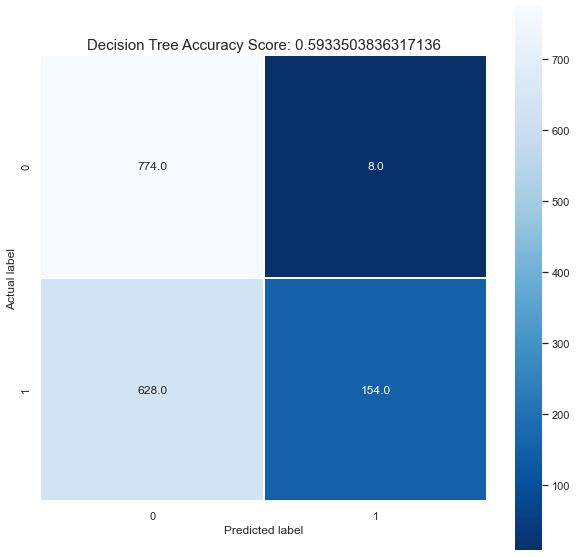

In [72]:
#Vẽ ma trận nhầm lẫn
cblof_cm = metrics.confusion_matrix(y_test, y_test_pred)
cblof_score = metrics.accuracy_score(y_test, y_test_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cblof_cm, annot=True, fmt=".1f", linewidths=.5, square = True, cmap = "Blues_r");
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
title = 'Decision Tree Accuracy Score: {0}'.format(cblof_score)
plt.title(title, size=15);

# TEMPORAL PROFILE

In [26]:
full_data = dt_reduced_copy.copy()
full_data.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [27]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   step      594643 non-null  int64  
 1   customer  594643 non-null  int16  
 2   age       594643 non-null  int8   
 3   gender    594643 non-null  int8   
 4   merchant  594643 non-null  int8   
 5   category  594643 non-null  int8   
 6   amount    594643 non-null  float64
 7   fraud     594643 non-null  int64  
dtypes: float64(1), int16(1), int64(2), int8(4)
memory usage: 17.0 MB


In [28]:
#Tính số lượng giao dịch hằng ngày của mỗi khách hàng
amo_df = full_data.value_counts(['customer','step']).to_frame('counts').reset_index()
print(amo_df)

        customer  step  counts
0           2522   170       5
1            769    47       5
2           3685    70       5
3           1838    20       5
4           1838    21       5
...          ...   ...     ...
572128      2688    94       1
572129      2688    95       1
572130      2688    96       1
572131      2688    97       1
572132         0    30       1

[572133 rows x 3 columns]


In [29]:
#Tính số lượng giao dịch hàng ngày tối đa của khách hàng tương ứng
amount_df = amo_df[['customer','counts']].groupby('customer').max().reset_index()
Sum_amount = {}
for i,row in amount_df.iterrows():
    Sum_amount[row.customer] = row.counts
for i,row in full_data.iterrows():
    full_data.at[i,'max_step_per_day'] = Sum_amount[row.customer]
full_data

,step,customer,age,gender,merchant,category,amount,fraud,max_step_per_day
0,0,210,4,2,30,12,4.55,0,3.0
1,0,2753,2,2,30,12,39.68,0,2.0
2,0,2285,4,1,18,12,26.89,0,2.0
3,0,1650,3,2,30,12,17.25,0,2.0
4,0,3585,5,2,30,12,35.72,0,2.0
...,...,...,...,...,...,...,...,...,...
594638,179,1639,3,1,18,12,20.53,0,2.0
594639,179,3369,4,1,18,12,50.73,0,2.0
594640,179,529,2,1,31,2,22.44,0,3.0
594641,179,1083,5,2,18,12,14.46,0,2.0


In [30]:
#Loại bỏ các khách hàng trùng nhau
temp_data = full_data.copy()
temp_data.drop_duplicates(subset ="customer", inplace = True)
temp_data

,step,customer,age,gender,merchant,category,amount,fraud,max_step_per_day
0,0,210,4,2,30,12,4.55,0,3.0
1,0,2753,2,2,30,12,39.68,0,2.0
2,0,2285,4,1,18,12,26.89,0,2.0
3,0,1650,3,2,30,12,17.25,0,2.0
4,0,3585,5,2,30,12,35.72,0,2.0
...,...,...,...,...,...,...,...,...,...
236475,79,3370,3,2,2,14,39.62,0,1.0
254227,85,2371,2,1,10,14,107.29,0,2.0
308714,101,30,1,1,42,11,20.80,0,2.0
309490,101,3785,4,1,37,2,44.28,0,2.0


In [32]:
#Tính giá trị trung bình cho tổng số tiền 
avg_sum_amount = temp_data['amount'].mean()
print("Giá trị trung bình của tổng số tiền: ", avg_sum_amount)

#Tính độ lệch chuẩn cho tổng số tiền 
std_sum_amount = temp_data['amount'].std()
print("Độ lệch chuẩn của tổng số tiền: ", std_sum_amount)

#Tính giá trị trung bình cho số lương giao dịch hàng ngày 
avg_count_amount = amo_df['counts'].mean()
print("Giá trị trung bình của số lượng giao dịch: ", avg_count_amount)

#Tính độ lệch chuẩn cho số lượng giao dịch hàng ngày
std_count_amount = amo_df['counts'].std()
print("Độ lệch chuẩn của số lượng giao dịch: ", std_count_amount)

#Tính giá trị trung bình cho số lượng giao dịch hàng ngày tối đa
avg_max_step_per_day = temp_data['max_step_per_day'].mean()
print("Giá trị trung bình của số lượng giao dịch hàng ngày tối đa: ", avg_max_step_per_day)

#Tính độ lệch chuẩn cho số lượng giao dịch hàng ngày tối đa
std_max_step_per_day = temp_data['max_step_per_day'].std()
print("Độ lệch chuẩn của số lượng giao dịch hàng ngày tối đa: ", std_max_step_per_day)

Giá trị trung bình của tổng số tiền:  70.16081712062258
Độ lệch chuẩn của tổng số tiền:  237.07552609379073
Giá trị trung bình của số lượng giao dịch:  1.0393439986856203
Độ lệch chuẩn của số lượng giao dịch:  0.21009713039878514
Giá trị trung bình của số lượng giao dịch hàng ngày tối đa:  2.22227626459144
Độ lệch chuẩn của số lượng giao dịch hàng ngày tối đa:  0.5715290561040238


In [ ]:
#Tính ngưỡng của tổng số tiền
threshold_sum_amount = (avg_sum_amount + std_sum_amount)
print("Ngưỡng của tổng số tiền: ", threshold_sum_amount)

# Tính ngưỡng của tổng số giao dịch
threshold_count_amount = (avg_count_amount + std_count_amount)
print("Ngưỡng của tổng số giao dịch: ", threshold_count_amount)

#Tính ngưỡng của số lượng giao dịch hàng ngày tối đa
threshold_max_step_per_day = (avg_max_step_per_day + std_max_step_per_day)
print("Ngưỡng của số lượng giao dịch hàng ngày tối đa: ", threshold_max_step_per_day)

In [ ]:
#Tính giá trị tổng số tiền tích lũy 
cumulative_data = full_data.copy()
cum_sum_df = cumulative_data[['customer','step','amount']].groupby(['customer','step']).cumsum().reset_index()
cum_sum_df

In [ ]:
#Gán vào data
cumulative_data['cumulat'] = cum_sum_df['amount'] 
cumulative_data

In [ ]:
#Tính giá trị tích lũy của tổng số giao dịch
cum_countdf = cumulative_data[['customer','step']].groupby(['customer','step']).cumcount().to_frame('cum_ct')
cum_countdf

In [ ]:
cumulative_data['cum_count'] = cum_countdf['cum_ct'] 
cumulative_data['cum_count'] = cumulative_data['cum_count']+1
cumulative_data

In [ ]:
#Tính giá trị tích lũy của tổng số giao dịch hằng ngày tối đa
cum_maxdf = cumulative_data[['customer','cum_count']].groupby(['customer']).cummax()
cum_maxdf

In [ ]:
cumulative_data['cum_max'] = cum_maxdf['cum_count'] 
cumulative_data

In [ ]:
#Tính delta giữa 2 đặc điểm giá trị tích lũy và ngưỡng của tổng số tiền
cumulative_data['delta_sum_amount'] = cumulative_data['cumulat'] - threshold_sum_amount

#Tính delta giữa 2 đặc điểm giá trị tích lũy và ngưỡng của tổng số tiền
cumulative_data['delta_count_amount'] = cumulative_data['cum_count'] - threshold_count_amount

#Tính delta giữa 2 đặc điểm giá trị tích lũy và ngưỡng của tổng số tiền
cumulative_data['delta_max_amount'] = cumulative_data['cum_max'] - threshold_max_step_per_day
cumulative_data

In [ ]:
#Tính điểm bất thường 
cumulative_data['anomaly_score'] = cumulative_data['delta_sum_amount'] + cumulative_data['delta_count_amount'] +cumulative_data['delta_max_amount']
cumulative_data

In [ ]:
#Lấy top 1000 giao dịch có điểm bất thường cao nhất
anomaly_top1000_data = cumulative_data.sort_values(by=['anomaly_score'],ascending=False)[:1000]

In [ ]:
#Xem danh sách 15 giao dịch trong top 1000. Có thể thấy có đến 15/15 giao dịch là lừa đảo
anomaly_top1000_data[:20]

In [ ]:
#Trong top 1000 có bao nhiêu giao dịch lừa đảo?
print(len(anomaly_top1000_data[lambda x:x['fraud']==1]))

In [ ]:
temp_test = cumulative_data['fraud']
temp_test.shape

In [ ]:
temp_score = cumulative_data['anomaly_score']
temp_score.shape

# ĐỘ ĐO ĐỘ CHÍNH XÁC CỦA MÔ HÌNH

In [93]:
from sklearn.metrics import roc_curve, roc_auc_score
#Tính AUC 
auc_hbos = roc_auc_score(hbos_test, hbos_result)
auc_cblof = roc_auc_score(y_test, y_test_scores)
auc_temp = roc_auc_score(temp_test, temp_score)

In [94]:
#Tính TPR và FPR 
false_positive_rate_hbos, true_positive_rate_hbos, threshold_hbos = roc_curve(hbos_test, hbos_result)
false_positive_rate_cblof, true_positive_rate_cblof, threshold_cblof = roc_curve(y_test, y_test_scores)
false_positive_rate_temp, true_positive_rate_temp, threshold_temp = roc_curve(temp_test, temp_score)

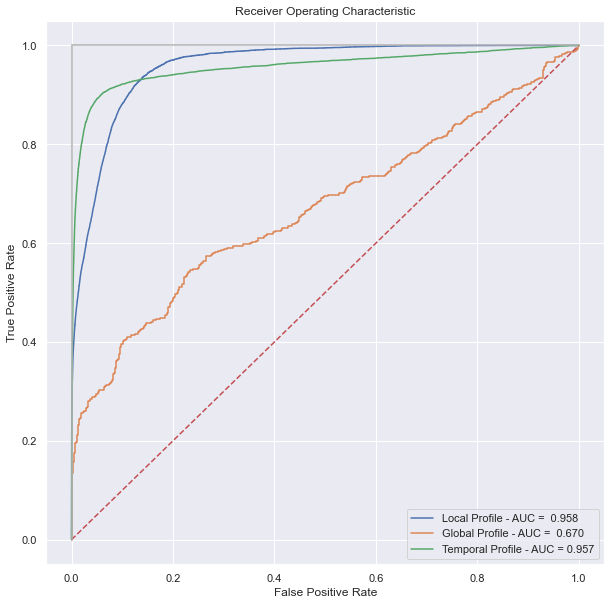

In [95]:
#Vẽ ROC của 3 profile
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate_hbos, true_positive_rate_hbos, label="Local Profile - AUC =  %.3f" %auc_hbos)
plt.plot(false_positive_rate_cblof, true_positive_rate_cblof, label="Global Profile - AUC =  %.3f" %auc_cblof)
plt.plot(false_positive_rate_temp, true_positive_rate_temp, label="Temporal Profile - AUC = %.3f" %auc_temp)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()